# Boston Calling: An Analysis of 3-1-1 Non-Emergency Service Requests

### ALY6140 Spring Q1-A 2019

__Instructor Kamen Madjarov__

__Stephen Howe__

__18 May 2019__

# Context and Background

The City of Boston has long provided mechanisms for residents and visitors to report non-emergency issues and service requests. Launched in 2015, Bos:311 replaced the Mayor's 24 hour hotline and a mobile application, Citizen Connect (WBUR News, 2015). The City of Boston now provides to its residents and visitors [four main ways](https://www.cityofboston.gov/311/) to report non-emergency issues. Individuals can report issues such as potholes, noise complaints, broken street lights, and the like to the city for repair and response (City of Boston, 2015). This document is an analysis of the service requests made to the City of Boston.

## Audience for Analysis

As a resident of Boston's Leather District and as a regular user of the city's 3-1-1 service, I am interested in knowing what type of service requests the city receives and how the city is responding. Specifically, _I want to understand the trends that describe service requests submitted to the City of Boston and the factors that impact the timely resolution of these tickets._

## Questions for Inquiry

The type of questions that I want to answer with this data include:

* How long does it take, on average, to close tickets?
* Which districts have the most complaints?
* What are the most common types of complaints?
* What % of tickets are closed by their expected date?
* Which departments receive the most requests?
* What factors impact the creation of service requests?
* What factors impact the timely resolution of service requests?
* Can we predict if a ticket will be closed ontime?

# Libraries
To begin the analysis, we need to first load the required functions and libraries. The first code cell loads a set of functions written specifically for this analysis and that are hosted in the accompanying .py file. The second code cell loads common Python libraries. Finally, the third code cell sets a configuration setting so that plots display in line with the rest of the notebook.

In [1]:
# Import functions
from ALY6140_StephenHowe_Functions_final import dt_conv, median_by_group, size_by_group, get_worksheet_names

In [2]:
# Import libraries
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

In [3]:
# configuration setting to display plots inline in the notebook
%matplotlib inline

This next line of code prints the current time. A second timestamp appears at the end of the notebook and is used to calculate the run-time for the notebook.

In [4]:
start = datetime.now()  # print current time
start

datetime.datetime(2019, 5, 17, 20, 5, 36, 294188)

# Data

## Description of Data

As part of Boston's [Open Data initiative](https://data.boston.gov), the city makes these 3-1-1 service requests available as a downloadable dataset. The [3-1-1 Service Requests](https://data.boston.gov/dataset/311-service-requests) dataset consists of approximately 1.5 million service requests from July 2011 through today and is updated daily. Please note that the data in this dataset starts before the City of Boston re-branded its non-emergency service requests intake system as Bos:311.

## Accessing the Data

For this analysis, I will import two different data sets. The main dataset, as described above, is a dataset of 3-1-1- service request tickets. The second dataset, also available from the same Boston open data site, is [demographic data for Boston's neighborhoods](https://data.boston.gov/dataset/neighborhood-demographics). This second dataset will be used to augment the primary analysis on service tickets.

### 3-1-1 Service Request Tickets

In the following code cells, I import the data from the Boston data site into a pandas dataframe. One column used for zipcodes is imported specifically as an object so that we don't lose the leading zeros and so that it can be used later as categorical data. The first and last few rows are displayed and the data type is confirmed to be a pandas dataframe.

_n.b._ The filepaths to the data used in this notebook are URLs pointing to the Boston data site. I also provide filepaths pointing to the data files saved to the working directory. These second filepaths are commented out in the code and will not run. This was done because in the course of completing this project, Boston removed one of the data sources I was using (page no longer exists; 500 errors) and I had to find a replacement data source. I am supplying copies of the data only as backup--they are not needed to run this notebook unless Boston changes its URLs.

In [5]:
# Set file pointer
# select one of the following sources: file or URL
# filename is only needed if URL is inaccessible

#data_path = "311requests.csv"  
data_path = "https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/2968e2c0-d479-49ba-a884-4ef523ada3c0/download/tmpzsfb3fzw.csv"

# Get data
# takes 3-4 minutes to fetch data if using URL; takes ~1 minute loading from file
bos311 = pd.read_csv(filepath_or_buffer=data_path,
                    header=0,
                    dtype={'location_zipcode': object},
                    low_memory=False)

This next cell is not run. It was used to download the data retrieved from the Boston data website so work can be done offline with a copy of the data.

In [6]:
# NOT RUN
# save data to .csv for backup and for working offline

#bos311.to_csv("311requests.csv")

Let's inspect the Boston 3-1-1 data. This data set includes metadata about when a ticket was open and closed, its ontime status, a description of the ticket, and other attributes describing the location of the issue, along with how the ticket was issued to the city.

In [7]:
bos311.head()  # inspect first few rows of data

,case_enquiry_id,open_dt,target_dt,closed_dt,ontime,case_status,closure_reason,case_title,subject,reason,...,police_district,neighborhood,neighborhood_services_district,ward,precinct,location_street_name,location_zipcode,latitude,longitude,source
0,101000295613,2011-07-01 01:32:33,2011-07-15 01:32:32,2011-07-01 05:06:58,ONTIME,Closed,Case Closed Case Resolved replaced 100 amp fus...,Street Light Outages,Public Works Department,Street Lights,...,B3,Greater Mattapan,7,Ward 17,1714,INTERSECTION Groveland St & River St,NaN,42.2715,-71.0772,Employee Generated
1,101000295614,2011-07-01 02:18:31,2011-07-05 02:18:31,2011-07-01 06:12:43,ONTIME,Closed,Case Closed Case Scheduled Items have been sch...,Schedule a Bulk Item Pickup,Public Works Department,Sanitation,...,E5,Roslindale,10,Ward 20,2008,39 Lorraine St,02131,42.2839,-71.1447,Self Service
2,101000295620,2011-07-01 06:24:38,2011-07-15 06:24:38,2011-08-23 10:33:03,OVERDUE,Closed,Case Closed Case Resolved Job Completed.,Street Light Outages,Public Works Department,Street Lights,...,E13,Roxbury,13,Ward 11,1103,INTERSECTION Bragdon St & Washington St,NaN,42.3173,-71.0968,Constituent Call
3,101000295624,2011-07-01 06:50:25,NaN,2011-07-01 06:50:29,ONTIME,Closed,Case Closed Internal Case,Highway Maintenance,Public Works Department,Highway Maintenance,...,C11,Dorchester,7,Ward 13,1309,1053 Dorchester Ave,02125,42.3594,-71.0587,Employee Generated
4,101000295625,2011-07-01 06:55:10,2011-07-05 06:55:10,2011-07-05 09:42:04,OVERDUE,Closed,Case Closed Case Resolved Delivered on 7/5. ...,Sticker Request,Public Works Department,Recycling,...,C6,South Boston / South Boston Waterfront,5,Ward 7,0701,392 K St,02127,42.3305,-71.0371,Self Service


In [8]:
bos311.tail(5)  # inspect last few rows of data

,case_enquiry_id,open_dt,target_dt,closed_dt,ontime,case_status,closure_reason,case_title,subject,reason,...,police_district,neighborhood,neighborhood_services_district,ward,precinct,location_street_name,location_zipcode,latitude,longitude,source
1502046,101002897116,2019-05-03 22:54:07,2019-05-09 08:30:00,NaN,ONTIME,Open,,Poor Conditions of Property,Public Works Department,Code Enforcement,...,B3,Dorchester,9,Ward 17,1703,35 Dunlap St,02124,42.2927,-71.0741,Citizens Connect App
1502047,101002897120,2019-05-03 23:21:39,NaN,NaN,ONTIME,Open,,Schedule Bulk Item Pickup,Public Works Department,Sanitation,...,E5,Roslindale,10,Ward 18,1810,16 Rawston Rd,02131,42.2778,-71.1294,Self Service
1502048,101002897121,2019-05-03 23:25:16,2019-05-07 08:30:00,NaN,ONTIME,Open,,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,...,C6,South Boston / South Boston Waterfront,5,6,0607,INTERSECTION O St & E First St,NaN,42.3594,-71.0587,Citizens Connect App
1502049,101002897123,2019-05-03 23:36:20,2019-05-07 08:30:00,NaN,ONTIME,Open,,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,...,A1,Boston,4,03,0308,31-39 Stuart St,02116,42.3513,-71.0638,Citizens Connect App
1502050,101002897125,2019-05-03 23:58:53,2019-05-07 08:30:00,NaN,ONTIME,Open,,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,...,D14,Allston / Brighton,15,Ward 21,2114,41 Strathmore Rd,02135,42.3374,-71.1471,Citizens Connect App


Confirm the datatype of the imported data:

In [9]:
type(bos311)  # pandas dataframe

pandas.core.frame.DataFrame

### Boston Demographic Data

With the 3-1-1 data loaded, I can now load the neighborhood demographic data. Up until May 13, 2019, Boston used to provide demographic data for all neighborhoods in a simple .csv. Each demographic segment (race, age, income, etc.) was separated into its own .csv file. Now, Boston provides all the demographic consolidated into a single Excel file with each neighborhood's data on its own worksheet. Organizing the file this way makes it more human-readable but there are more steps involved to extract the data for our purposes. For now, I will read the file from the Boston data site and display the worksheet names contained in the Excel file. Later on in this analysis, I will extract the specific demographic data we need. The code cell below uses a bespoke function that reads an Excel file and returns the list of worksheet names in a dataframe.

In [10]:
# set file pointer
# select URL or filename
# filename is only needed if URL is inaccessible

data_path2 = "https://data.boston.gov/dataset/8202abf2-8434-4934-959b-94643c7dac18/resource/7154cc09-55c4-4acd-99a5-3a233d11e699/download/neighborhoodsummaryclean_1950-2010.xlsx"
#data_path2 = "neighborhoodsummaryclean_1950-2010.xlsx"

In [11]:
get_worksheet_names(data_path2) # Display worksheet names

['Allston',
 'Back Bay',
 'Beacon Hill',
 'Brighton',
 'Charlestown',
 'Dorchester',
 'Downtown',
 'East Boston',
 'Fenway',
 'Harbor Islands',
 'Hyde Park',
 'Jamaica Plain',
 'Longwood Medical Area',
 'Mattapan',
 'Mission Hill ',
 'North End',
 'Roslindale',
 'Roxbury',
 'South Boston Waterfront',
 'South Boston',
 'South End',
 'West End',
 'West Roxbury']

# Data Clean-Up

In this section, I will do some initial clean-up of the data (e.g. convert strings to timedate) as well as create new, derivative columns in the data set that will be used later on in the analysis. For example, I will calculate the duration it took to resolve a ticket and transform that `timedelta` to a `float` so that it can be used in calculations and plotting.

## String to Datetime Conversion
A quick glance at the imported data types show that additional clean-up work is needed. For example, the date fields (`open_dt`, `target_dt`, and `closed_dt`) are stored as strings. We can do this conversion by calling one of the customized functions contained in the imported Python file.

In [12]:
bos311.dtypes

case_enquiry_id                     int64
open_dt                            object
target_dt                          object
closed_dt                          object
ontime                             object
case_status                        object
closure_reason                     object
case_title                         object
subject                            object
reason                             object
type                               object
queue                              object
department                         object
submittedphoto                     object
closedphoto                        object
location                           object
fire_district                      object
pwd_district                       object
city_council_district              object
police_district                    object
neighborhood                       object
neighborhood_services_district     object
ward                               object
precinct                          

In [13]:
# Convert date columns to datetime from string
dt_conv(bos311, 'open_dt')
dt_conv(bos311, 'target_dt')
dt_conv(bos311, 'closed_dt')

bos311.dtypes  # confirm datatype conversion

case_enquiry_id                            int64
open_dt                           datetime64[ns]
target_dt                         datetime64[ns]
closed_dt                         datetime64[ns]
ontime                                    object
case_status                               object
closure_reason                            object
case_title                                object
subject                                   object
reason                                    object
type                                      object
queue                                     object
department                                object
submittedphoto                            object
closedphoto                               object
location                                  object
fire_district                             object
pwd_district                              object
city_council_district                     object
police_district                           object
neighborhood        

## New Columns

For the analysis, I need some new variables that I can derive from the orignal data. For example, I have open and closed dates for service tickets, but it would be useful to have the actual duration for which a ticket was open. This can be done by creating a new column that calculates the duration between these two dates. This column will be named `duration`.

In [14]:
# Create time delta for resolution duration
bos311['duration'] = bos311['closed_dt'] - bos311['open_dt']
bos311['duration'].head(10)

0    0 days 03:34:25
1    0 days 03:54:12
2   53 days 04:08:25
3    0 days 00:00:04
4    4 days 02:46:54
5    0 days 00:09:13
6    0 days 00:00:40
7    0 days 00:00:19
8    0 days 00:00:28
9                NaT
Name: duration, dtype: timedelta64[ns]

The column created above is of the dtype `timedelta64[ns]`. This data type is convenient for displaying the time but it is not a format that is easily consumable by matplotlib. Below, I create yet a another column that contains the resolution duration in hours as a float. Finding the appropriate unit of time is not an obvious choice. Some tickets are closed in seconds while others take months and years. I am choosing hours because it most closely fits with people's expectations of an appropriate response.

In [15]:
# convert timedelta to hours as float
bos311['duration_hours'] = bos311['duration'].apply(lambda x: float((x.seconds/3600)+(x.days *24)))
bos311['duration_hours'].head(10)

0       3.573611
1       3.903333
2    1276.140278
3       0.001111
4      98.781667
5       0.153611
6       0.011111
7       0.005278
8       0.007778
9            NaN
Name: duration_hours, dtype: float64

There are additional data conversions and derivatives that I will need to create, but these actions will be executed later on in the notebook in the context of a specific question I am trying to answer.

# Descriptive Analytics

With the data loaded and some initial data-cleansing complete, I can now describe the data in order to answer some of the questions posed at the beginning of this notebook. I will start with what I have labeled duration, or, the time it took from when a ticket was opened to the time it was closed.

## Resolution Duration

Let's begin by extracting the resolution duration. This can be done by selecting those tickets that have been marked as 'Closed' by the City and getting the duration in hours calculated in the clean-up section.

In [16]:
resolution_time = bos311.loc[bos311['case_status']=='Closed', 'duration_hours']
resolution_time.head(5)

0       3.573611
1       3.903333
2    1276.140278
3       0.001111
4      98.781667
Name: duration_hours, dtype: float64

Executing a quick statistical description on the duration time reveals a hugely variable set of times. The resolution duration ranges from seconds to years!!

In [17]:
resolution_time.describe()

count    1.379850e+06
mean     5.057374e+02
std      2.078145e+03
min     -1.611111e-02
25%      1.518611e+00
50%      2.152556e+01
75%      1.597068e+02
max      6.441159e+04
Name: duration_hours, dtype: float64

While it may be tempting to remove these extremes as outliers, examining them more closely helps to illuminate the data. For instance, did a ticket really take more than 64,000 hours (7.3 years) to close? If we slice the data for records with a duration > 64,000 hours, we can then retrieve the ticket information. This ticket for road repair was opened in September 2011 and was closed in January 2019. 

In [18]:
outlier_long = resolution_time.loc[resolution_time > 64000] # get tickets with duration > 64000 hours
bos311.iloc[outlier_long.index[0]]  # get record info

case_enquiry_id                                                        101000328232
open_dt                                                         2011-09-12 15:27:57
target_dt                                                                       NaT
closed_dt                                                       2019-01-17 11:03:30
ontime                                                                       ONTIME
case_status                                                                  Closed
closure_reason                    Case Closed. Closed date : 2019-01-17 11:03:30...
case_title                                                           Roadway Repair
subject                                                     Public Works Department
reason                                                          Highway Maintenance
type                                                                 Roadway Repair
queue                                           PWDx_Roadway Repair_ARP_Resu

We can do the same for tickets at the other side of the data: tickets open for less than 1 minute. Case enquiry_id 10100295643 was closed at the same time it was opened. This is probably the case where an issue was reported after the fact. This process is a good way, perhaps, for the City to track __THAT__ work was done but it doesn't help to communicate real response time. In the second code cell that follows, we can see that there are over 17000 tickets that took less than 1 minute to close.

In [19]:
outlier_short = resolution_time.loc[resolution_time < 0.00027] # get tickets with duration < 1 minute
bos311.iloc[outlier_short.index[0]]  # get record info

case_enquiry_id                                                        101000295643
open_dt                                                         2011-07-01 08:03:09
target_dt                                                                       NaT
closed_dt                                                       2011-07-01 08:03:09
ontime                                                                       ONTIME
case_status                                                                  Closed
closure_reason                    Case Closed Internal Case Performed by Highway...
case_title                                                Pothole Repair (Internal)
subject                                                     Public Works Department
reason                                                          Highway Maintenance
type                                                      Pothole Repair (Internal)
queue                                            PWDx_District 07: South Dor

In [20]:
len(outlier_short) # display the number of tickets with a duration of < 1 minute

17659

## Refining the Definition of Duration

While tickets that are closed within seconds and tickets that are open for years both appear to be legitimate service cases, they are not very helpful when trying to gain an understanding of typical resolution times. This is especially true when tickets are created after the work has been done or when a 3-1-1 service request is closed in seconds only because a ticket was opened in another ticketing system. I will return to the duration times _with_ these outliers in it, but for the moment I will subset the tickets to those falling into a more interpretable time range. The range I have selected is all closed tickets with a resolution duration between 30 minutes and 1 month. Doing so gives us a set of over 1 million closed tickets (down from 1.4 million before the subsetting).

In [21]:
resolution_time2 = resolution_time.loc[(resolution_time > 0.5) & (resolution_time < 720)]
len(resolution_time2)

1021848

Running the `.describe()` method on our duration hours, we can observe that the average resolution duration time is just under 9 hours.

In [22]:
resolution_time2.describe()

count    1.021848e+06
mean     8.987278e+01
std      1.371197e+02
min      5.002778e-01
25%      4.022500e+00
50%      2.475583e+01
75%      1.189842e+02
max      7.199981e+02
Name: duration_hours, dtype: float64

Plotting the subsetted data shows that the majority of closed service request tickets had a resolution duration of under just over 24 hours.

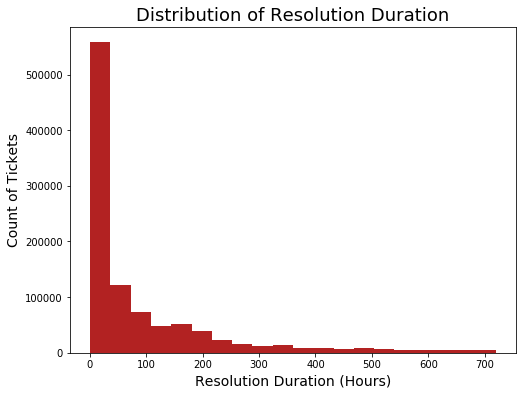

In [23]:
plt.figure(figsize=(8,6)) 
plt.hist(resolution_time2,
        bins = 20,
        density=False,
        color="#B22222")
plt.title('Distribution of Resolution Duration', fontsize=18)
plt.xlabel('Resolution Duration (Hours)', fontsize=14)
plt.ylabel('Count of Tickets', fontsize=14)

plt.show()

## Resolution Duration by Groups

Knowing that the majority of closed tickets were resolved in about a day may be helpful to the City and its residents. This number provides some level of benchmark for people to evaluate when their ticket may be resolved. However, it would be helpful to know if different kinds of tickets have different resolution times. To get these answers, let's first create a new dataframe with all the columns from the original data set, filtering for closed tickets with resolution duration between 30 minutes and 1 month.

In [24]:
bos311_closed = bos311.loc[(bos311['case_status'] == 'Closed') &
                           (bos311['duration_hours'] > 0.5) &
                           (bos311['duration_hours'] < 720)]

In [25]:
bos311_closed['duration_hours'].describe()  # same numbers as before, as expected

count    1.021848e+06
mean     8.987278e+01
std      1.371197e+02
min      5.002778e-01
25%      4.022500e+00
50%      2.475583e+01
75%      1.189842e+02
max      7.199981e+02
Name: duration_hours, dtype: float64

### What Can We Learn From Groups?
In this section, I look at the resolution duration through the lens of different groups. For example, what is the median time a ticket was open when grouped by Boston neighborhood? To do this, I have created a custom function, `median_by_group` that groups a dataframe by one column and calculates the median for each group on another column.

#### Resolution Time by Neighborhood

Grouping by neighborhood and getting the median duration for a resolved ticket, we can view the neighborhoods that experience the longest time for closed tickets and we can view the neighborhoods that experience the shortest time for closed tickets. Mattapan, West Roxbury, and Dorchester experience the slowest resolution time and Beacon Hill, Downtown, the South End and South Boston experience the quickest resolution time--more than three times as fast.

In [26]:
median_by_group(bos311_closed, "neighborhood", "duration_hours").head()

,neighborhood,duration_hours
13,Greater Mattapan,51.237778
16,Mattapan,48.368611
0,,47.445278
23,West Roxbury,47.330556
9,Dorchester,40.460556


In [27]:
median_by_group(bos311_closed, "neighborhood", "duration_hours").tail()

,neighborhood,duration_hours
20,South Boston,19.677778
10,Downtown / Financial District,17.875556
22,South End,17.658472
21,South Boston / South Boston Waterfront,16.694722
4,Beacon Hill,15.592778


The results don't vary much if we perform this same calculation on _all tickets_, not just closed tickets with durations between 30 minutes and 30 days, although now Allson and Brighton join the group with slowest to close tickets. Interestingly, the tickets without a neighborhood indicated jump from the slowest group to the quickest resolved.

In [28]:
median_by_group(bos311, "neighborhood", "duration_hours").head()

,neighborhood,duration_hours
16,Mattapan,45.673611
13,Greater Mattapan,43.447778
1,Allston,39.169444
9,Dorchester,30.425417
6,Brighton,25.630417


In [29]:
median_by_group(bos311, "neighborhood", "duration_hours").tail()

,neighborhood,duration_hours
22,South End,17.751389
0,,17.634167
10,Downtown / Financial District,16.216250
21,South Boston / South Boston Waterfront,15.627778
4,Beacon Hill,13.821806


#### Resolution Time by Ticket Subject
Another important variable in the ticket data is the subject for the ticket. Using the same `median_by_group` function used above, we can determine which ticket subjects take the longest amount of time to close and which subjects take the shortest. These calculations are performed on the subsetted data of closed tickets with durations between 30 minutes and 1 month.

Property Management, Civil Rights, Inspectional Services are among the slowest while Consumer Affairs & Licensing, Transportion, and Public Works are among the quickest. Intuitively, this makes sense because the nature of the cases handled for Civil Rights issues (e.g. claim of racial discrimination) could require more time than a case handled by Public Works (e.g. fixing a pothole).

In [30]:
median_by_group(bos311_closed, "subject", "duration_hours").head()

,subject,duration_hours
10,Property Management,163.500278
3,Civil Rights,148.315833
6,Inspectional Services,138.836111
14,Youthline,127.395278
5,Disability Department,118.580556


In [31]:
median_by_group(bos311_closed, "subject", "duration_hours").tail()

,subject,duration_hours
13,Veterans,24.346111
11,Public Works Department,23.175694
7,Mayor's 24 Hour Hotline,20.445972
12,Transportation - Traffic Division,11.797500
4,Consumer Affairs & Licensing,10.301111


#### Resolution Time by Ticket Reasons
One final slice I will make of the data is to view the median duration for closed tickets by ticket reason. Ticket reason describes the type of work the service request is asking for. Tickets about installing signs in designated hero squares take the longest while the needle program and street cleaning are among the quickest.

In [32]:
median_by_group(bos311_closed, "reason", "duration_hours").head()

,reason,duration_hours
27,Hero Square Sign,431.213056
29,Housing,210.966111
0,Abandoned Bicycle,170.809167
20,Environmental Services,169.158333
30,Investigations and Enforcement,166.982222


In [33]:
median_by_group(bos311_closed, "reason", "duration_hours").tail()

,reason,duration_hours
14,Code Enforcement,10.194444
48,Street Cleaning,5.416667
19,Enforcement & Abandoned Vehicles,4.050556
33,Needle Program,3.197500
10,Call Center Intake,1.556667


## Does Race Matter?
Viewing the resolution duration times by groupings of neighborhood, ticket subject, and ticket reason are helpful ways to gain more insight on what drives the length of time it will take to close a ticket. I can take this one level deeper to examine what other factors may be at play in the resolution duration. Why, for example, would the neighborhood impact the resolution duration? Proximity to resources? The importance of the constituency to politicians? Income? What follows is by no means a definitive or exhaustive analysis of potential factors connecting neighborhood and resolution duration. I will, however, look at one dimension--race--to examine its role in resolution duration.

For this analysis, I will use the race and ethnicity data from the Boston census data described at the beginning of this notebook. The data I want is from the 2010 census data (the most recent available). To begin, we need to isolate the demographic data that we want. As I mentioned earlier, all the demographic data, from 1950 - 2010, is contained in one Excel file. Each neighborhood's data is on its own, separate worksheet in the same file.

I have written a function below that takes as its argument the name of one of the worksheets in the census data Excel file. The function will return the value for the percentage of whites in the 2010 data.

For example, if we want to get the percentage of whites in Roxbury for 2010, we can execute the following code:

In [34]:
# function to get value at row 'White' and column 'Unnamed: 14', which is the location of 2010 population percentages

def get_worksheet_data(sheet_name):
    mydata = pd.read_excel(data_path2,
                          sheet_name=sheet_name,
                           index_col=0)
    return mydata.at['White', 'Unnamed: 14']

In [35]:
get_worksheet_data('Roxbury')

0.10185090916495286

Now we can use this function to get the data we need for all neighborhoods. Using the `get_worksheet_names` function we can get the list of worksheets. Using Python's `apply` function, we can apply the `get_worksheet_data` function to the list of worksheets. All the results are then combined into a dataframe.

In [36]:
mylist = get_worksheet_names(data_path2)
percentages = pd.Series(mylist).apply(get_worksheet_data)
percentages

0     0.574041
1     0.787871
2     0.868004
3     0.697751
4     0.757832
5     0.221639
6     0.579102
7     0.371556
8     0.648916
9     0.308411
10    0.282452
11    0.536310
12    0.695536
13    0.063733
14    0.473628
15    0.916357
16    0.506789
17    0.101851
18    0.855694
19    0.782514
20    0.541132
21    0.636179
22    0.732534
dtype: float64

Now, we can put everything together and create a dataframe of neigbhorhood names and percentage of the population that is white in that neighborhood.

In [37]:
race = pd.DataFrame(mylist, percentages).reset_index()
race.columns = ['Percent', 'Neighborhood']

In [38]:
race

,Percent,Neighborhood
0,0.574041,Allston
1,0.787871,Back Bay
2,0.868004,Beacon Hill
3,0.697751,Brighton
4,0.757832,Charlestown
5,0.221639,Dorchester
6,0.579102,Downtown
7,0.371556,East Boston
8,0.648916,Fenway
9,0.308411,Harbor Islands


Next, I am going to save the median duration hours by neighborhood into a new dataframe, `neighborhood_hours`.

In [39]:
neighborhood_hours = median_by_group(bos311_closed, "neighborhood", "duration_hours")
neighborhood_hours.head()

,neighborhood,duration_hours
13,Greater Mattapan,51.237778
16,Mattapan,48.368611
0,,47.445278
23,West Roxbury,47.330556
9,Dorchester,40.460556


Then, I can merge the two dataframes, one containing the percentage of whites and the other containing median resolution duration, by neighborhood name. I will subset the merged dataframes by those that have percent of population figures (the ticket data set has more neighborhood names than the demographic data so those neighborhoods are missing population data in the merged set).

In [40]:
combined = pd.merge(neighborhood_hours, race, how='left', left_on='neighborhood', right_on='Neighborhood')
combined_final = combined.loc[combined['Percent'] > 0]
combined_final

,neighborhood,duration_hours,Percent,Neighborhood
1,Mattapan,48.368611,0.063733,Mattapan
3,West Roxbury,47.330556,0.732534,West Roxbury
4,Dorchester,40.460556,0.221639,Dorchester
5,Allston,40.186944,0.574041,Allston
7,Roslindale,35.733611,0.506789,Roslindale
8,Hyde Park,34.718611,0.282452,Hyde Park
9,Jamaica Plain,29.332500,0.536310,Jamaica Plain
10,Charlestown,25.895278,0.757832,Charlestown
11,Brighton,25.880278,0.697751,Brighton
13,East Boston,24.759861,0.371556,East Boston


### Are Race and Resolution Duration Correlated?
We can answer this question by fitting a linear regression model on our data, calculating the regression line for how the percentage of whites in a neighborhood's population is correlated to the resolution duration. The results show a negative correlation: as the percentage of whites increases in a neighborhood, the resolution duration goes down. The results are not strongly significant. The r-squared value is only 0.213, meaning that only 21% of the change we observe in resolution duration can be explained by the percentage of whites in the neighborhood. The p-value, well reasonable at 0.084, is greater than the normally used p-value of 0.05. We also receive a Python warning because our sample size (i.e. number of neighborhoods) is small.

The results, while not statistically strong, remain sobering.

In [41]:
results = smf.ols('duration_hours ~ Percent', data = combined_final).fit()
print(results.params)
results.summary()

Intercept    39.781424
Percent     -18.652809
dtype: float64


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         duration_hours   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     3.511
Date:                Fri, 17 May 2019   Prob (F-statistic):             0.0836
Time:                        20:07:34   Log-Likelihood:                -54.291
No. Observations:                  15   AIC:                             112.6
Df Residuals:                      13   BIC:                             114.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.7814      5.766      6.900      0.000      27.325      52.237
Percent      -18.6528      9.954     -1.874      0.084     -40.157       2.852
==============================================================================
Omnibus:                        1.809   Durbin-Watson:                   0.583
Prob(Omnibus):                  0.405   Jarque-Bera (JB):                0.944
Skew:                           0.613   Prob(JB):                        0.624
Kurtosis:                       2.904   Cond. No.                         5.11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0,0.5,'Resolution Duration (Hours)')

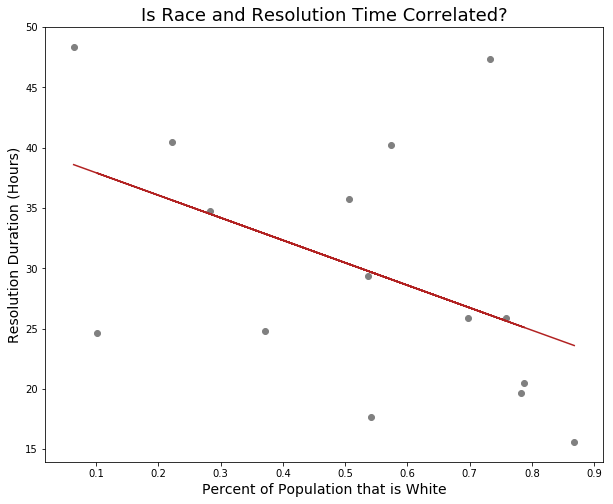

In [42]:
plt.figure(figsize=(10,8))
plt.scatter(combined_final.Percent, combined_final.duration_hours, color="grey")
plt.plot(combined_final.Percent, results.fittedvalues, color="#B22222")
plt.title("Is Race and Resolution Time Correlated?", fontsize=18)
plt.xlabel('Percent of Population that is White', fontsize=14)
plt.ylabel('Resolution Duration (Hours)', fontsize=14)

### Other Factors?
Could other demographic factors play a role in determining resolution duration? Income or education level are two possibilities, but income is not part of the demographic dataset and education level is not available for 2010. Below, I run the same linear regression as above but on the % of the population in a neighborhood who are renters. The thinking here is that renters are perceived to be a transient population and may not garner a strong institutional response from the City. However, I primarily do this calculation to provide a point of comparison to race.

The findings are even less strong than race. The r-square value is .08 and the p-value is not significant.

In [43]:
def get_worksheet_data2(sheet_name):
    mydata = pd.read_excel(data_path2,
                          sheet_name=sheet_name,
                           index_col=0)
    return mydata.at['Renter-occupied', 'Unnamed: 14']

percentages_renters = pd.Series(mylist).apply(get_worksheet_data2)

renters = pd.DataFrame(mylist, percentages_renters).reset_index()
renters.columns = ['Percent', 'Neighborhood']

combined2 = pd.merge(neighborhood_hours, renters, how='left', left_on='neighborhood', right_on='Neighborhood')
combined_final2 = combined2.loc[combined2['Percent'] > 0]

results2 = smf.ols('duration_hours ~ Percent', data = combined_final2).fit()
print(results2.params)
results2.summary()

Intercept    43.626817
Percent     -21.775760
dtype: float64


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         duration_hours   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.217
Date:                Fri, 17 May 2019   Prob (F-statistic):              0.290
Time:                        20:07:50   Log-Likelihood:                -55.413
No. Observations:                  15   AIC:                             114.8
Df Residuals:                      13   BIC:                             116.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     43.6268     12.598      3.463      0.004      16.411      70.842
Percent      -21.7758     19.736     -1.103      0.290     -64.412      20.860
==============================================================================
Omnibus:                        1.334   Durbin-Watson:                   0.252
Prob(Omnibus):                  0.513   Jarque-Bera (JB):                1.058
Skew:                           0.455   Prob(JB):                        0.589
Kurtosis:                       2.069   Cond. No.                         10.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Counts of Service Request Ticket
I have spent a lot of time in the sections above analyzing the overall duration needed to resolve a closed ticket. Another way we can view these service requests is by the overall number of service requests made. We can see, for example, that Dorchester has the largest number of service requests and Chestnut Hill has the fewest.

In [44]:
tickets_all = pd.DataFrame(size_by_group(bos311, 'neighborhood', 'case_enquiry_id'))
tickets_all = tickets_all.reset_index()
tickets_all.columns = ['neighborhood', 'request_count']
tickets_all.sort_values(['request_count'],ascending=False)

,neighborhood,request_count
9,Dorchester,219269
19,Roxbury,134780
2,Allston / Brighton,107589
21,South Boston / South Boston Waterfront,100817
15,Jamaica Plain,100400
10,Downtown / Financial District,90791
11,East Boston,82591
14,Hyde Park,70794
22,South End,70651
23,West Roxbury,70527


### Tickets Over Time
The overall count of tickets is interesting, but not immediatley useful. We can, however, look at counts of tickets over time to try and identify useful trends. In order to do this, I will add a column to hold the calendar year for when each ticket was opened.

In [45]:
# Add year to data
bos311['open_dt_year'] = bos311['open_dt'].apply(lambda x: x.strftime('%B-%Y')) 
bos311.head()

,case_enquiry_id,open_dt,target_dt,closed_dt,ontime,case_status,closure_reason,case_title,subject,reason,...,ward,precinct,location_street_name,location_zipcode,latitude,longitude,source,duration,duration_hours,open_dt_year
0,101000295613,2011-07-01 01:32:33,2011-07-15 01:32:32,2011-07-01 05:06:58,ONTIME,Closed,Case Closed Case Resolved replaced 100 amp fus...,Street Light Outages,Public Works Department,Street Lights,...,Ward 17,1714,INTERSECTION Groveland St & River St,NaN,42.2715,-71.0772,Employee Generated,0 days 03:34:25,3.573611,July-2011
1,101000295614,2011-07-01 02:18:31,2011-07-05 02:18:31,2011-07-01 06:12:43,ONTIME,Closed,Case Closed Case Scheduled Items have been sch...,Schedule a Bulk Item Pickup,Public Works Department,Sanitation,...,Ward 20,2008,39 Lorraine St,02131,42.2839,-71.1447,Self Service,0 days 03:54:12,3.903333,July-2011
2,101000295620,2011-07-01 06:24:38,2011-07-15 06:24:38,2011-08-23 10:33:03,OVERDUE,Closed,Case Closed Case Resolved Job Completed.,Street Light Outages,Public Works Department,Street Lights,...,Ward 11,1103,INTERSECTION Bragdon St & Washington St,NaN,42.3173,-71.0968,Constituent Call,53 days 04:08:25,1276.140278,July-2011
3,101000295624,2011-07-01 06:50:25,NaT,2011-07-01 06:50:29,ONTIME,Closed,Case Closed Internal Case,Highway Maintenance,Public Works Department,Highway Maintenance,...,Ward 13,1309,1053 Dorchester Ave,02125,42.3594,-71.0587,Employee Generated,0 days 00:00:04,0.001111,July-2011
4,101000295625,2011-07-01 06:55:10,2011-07-05 06:55:10,2011-07-05 09:42:04,OVERDUE,Closed,Case Closed Case Resolved Delivered on 7/5. ...,Sticker Request,Public Works Department,Recycling,...,Ward 7,0701,392 K St,02127,42.3305,-71.0371,Self Service,4 days 02:46:54,98.781667,July-2011


Using the `size_by_group` function, I can calculate the number of service requests by year. I then reset the index, change the column names, and sort the data by the date for easy plotting later. I also print the datatype for each variable to confirm that we have data in the correct format.

In [46]:
ticket_count = pd.DataFrame(size_by_group(bos311, 'open_dt_year', 'case_enquiry_id'))
ticket_count = ticket_count.reset_index()
ticket_count.columns = ['open_dt_year', 'ticket_count']
ticket_count['open_dt_year'] = pd.to_datetime(ticket_count['open_dt_year'])
ticket_count = ticket_count.sort_values(['open_dt_year'])
ticket_count.head()

,open_dt_year,ticket_count
40,2011-07-01,9854
8,2011-08-01,11547
87,2011-09-01,10427
79,2011-10-01,9999
71,2011-11-01,8087


In [47]:
ticket_count.dtypes

open_dt_year    datetime64[ns]
ticket_count             int64
dtype: object

Since this dataset is updated daily, the current month (May 2019) is incomplete. I am going to drop May-2019 because the count of total tickets will be partial and will not be representative on the plot.

In [48]:
ticket_count_notmay19 = ticket_count.loc[(ticket_count['open_dt_year'] >= '2011-07-01') & 
                                         (ticket_count['open_dt_year'] < '2019-05-01')]
ticket_count_notmay19.tail()

,open_dt_year,ticket_count
23,2018-12-01,16676
39,2019-01-01,19534
31,2019-02-01,17084
62,2019-03-01,24661
7,2019-04-01,20404


#### Plot the Results
Now, we can plot the data. The chart below shows the count, by month, of the service requests opened since 2011. The overall trend is an increase of service requests. The reason behind this is not clear as it may just be an indication that more people are using the Bos:311 system and not an actual increase in the number of problems. 

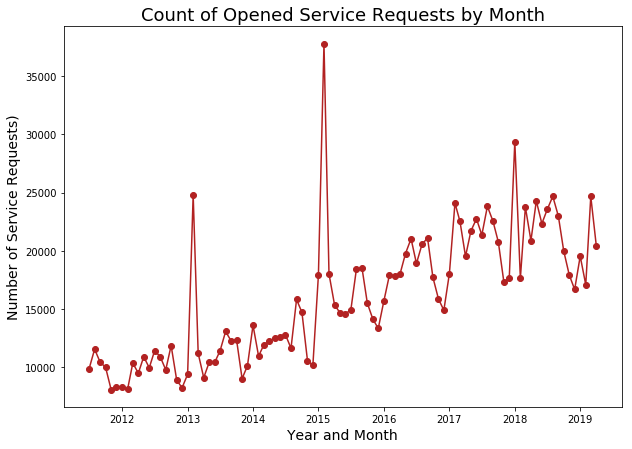

In [49]:
plt.figure(figsize=(10,7))
plt.plot_date(x=ticket_count_notmay19['open_dt_year'],
              y=ticket_count_notmay19['ticket_count'],
             ls="-",
             color="#B22222")
plt.title("Count of Opened Service Requests by Month", fontsize=18)
plt.xlabel("Year and Month", fontsize=14)
plt.ylabel("Number of Service Requests)", fontsize=14)
plt.show()

#### Snowpocalypse
One question remains with this chart: why is there such a huge spike of service requests in early 2015? For those of us living in Boston at the time, we know of early 2015 as the year where Boston experienced inordinate amounts of snowfall. Can we see the affects of the snow in the service requests data? 

If we slice the data for just Feburary 2015, we can then group by the reason behind the tickets. We can observe the 'street cleaning' (e.g. includes snow removal) as the driver behind these service requests with over 22,000 tickets. Sanitation adds another 5200 tickets that month.

In [50]:
snow = bos311.loc[bos311['open_dt_year'] == "February-2015"]
snow.groupby(by=['reason']).size()

reason
Abandoned Bicycle                              2
Administrative & General Requests            956
Air Pollution Control                          1
Alert Boston                                  58
Animal Issues                                235
Billing                                        1
Bridge Maintenance                             1
Building                                     448
Call Inquiry                                 136
Catchbasin                                    46
Cemetery                                       5
Code Enforcement                               6
Disability                                    69
Employee & General Comments                 1558
Enforcement & Abandoned Vehicles             653
Environmental Services                        64
Fire Department                              450
Fire Hydrant                                  31
Generic Noise Disturbance                      4
Graffiti                                      94
Health       

# Making Predictions
One last type of analysis that we can conduct on this data is to try and predict a future outcome of a ticket. For example, can I develop a model that will predict whether or not a ticket will be resolved ontime? In order to work with many of the predictive analytics libraries in Python, we need to prep the data to be in the correct format (e.g. numeric, not strings). The next few code cells do just that. 

## Prepping the Data

To begin, I need to create a subset of the data for tickets that have a `ontime` status of either 'ONTIME' or 'OVERDUE'. This variable will be our target variable. I also convert this target variable to 0 and 1s, where 0 = OVERDUE and 1 = ONTIME.

In [51]:
bos311_binary = bos311.loc[(bos311['ontime'] == 'ONTIME') | (bos311['ontime'] == 'OVERDUE')].copy()
bos311_binary['target'] = np.where(bos311_binary['ontime'].str.contains("ONTIME"), 1, 0)
bos311_binary.head()

,case_enquiry_id,open_dt,target_dt,closed_dt,ontime,case_status,closure_reason,case_title,subject,reason,...,precinct,location_street_name,location_zipcode,latitude,longitude,source,duration,duration_hours,open_dt_year,target
0,101000295613,2011-07-01 01:32:33,2011-07-15 01:32:32,2011-07-01 05:06:58,ONTIME,Closed,Case Closed Case Resolved replaced 100 amp fus...,Street Light Outages,Public Works Department,Street Lights,...,1714,INTERSECTION Groveland St & River St,NaN,42.2715,-71.0772,Employee Generated,0 days 03:34:25,3.573611,July-2011,1
1,101000295614,2011-07-01 02:18:31,2011-07-05 02:18:31,2011-07-01 06:12:43,ONTIME,Closed,Case Closed Case Scheduled Items have been sch...,Schedule a Bulk Item Pickup,Public Works Department,Sanitation,...,2008,39 Lorraine St,02131,42.2839,-71.1447,Self Service,0 days 03:54:12,3.903333,July-2011,1
2,101000295620,2011-07-01 06:24:38,2011-07-15 06:24:38,2011-08-23 10:33:03,OVERDUE,Closed,Case Closed Case Resolved Job Completed.,Street Light Outages,Public Works Department,Street Lights,...,1103,INTERSECTION Bragdon St & Washington St,NaN,42.3173,-71.0968,Constituent Call,53 days 04:08:25,1276.140278,July-2011,0
3,101000295624,2011-07-01 06:50:25,NaT,2011-07-01 06:50:29,ONTIME,Closed,Case Closed Internal Case,Highway Maintenance,Public Works Department,Highway Maintenance,...,1309,1053 Dorchester Ave,02125,42.3594,-71.0587,Employee Generated,0 days 00:00:04,0.001111,July-2011,1
4,101000295625,2011-07-01 06:55:10,2011-07-05 06:55:10,2011-07-05 09:42:04,OVERDUE,Closed,Case Closed Case Resolved Delivered on 7/5. ...,Sticker Request,Public Works Department,Recycling,...,0701,392 K St,02127,42.3305,-71.0371,Self Service,4 days 02:46:54,98.781667,July-2011,0


### Selecting Features
Next, I am going to create a dataframe with just the target variables and the features that I think will be useful in the model. For example, I don't want the column `closed_dt` because it is too highly dependent with the `ontime` column. To begin, I will select these columns: `reason`, `subject`, `neighborhood`, and `source`. I will revisit this decision in a bit.

In [52]:
# create my data

bos311_pred = pd.DataFrame(bos311_binary[['target', 'reason', 'subject', 'neighborhood', 'source']])
bos311_pred.head()

,target,reason,subject,neighborhood,source
0,1,Street Lights,Public Works Department,Greater Mattapan,Employee Generated
1,1,Sanitation,Public Works Department,Roslindale,Self Service
2,0,Street Lights,Public Works Department,Roxbury,Constituent Call
3,1,Highway Maintenance,Public Works Department,Dorchester,Employee Generated
4,0,Recycling,Public Works Department,South Boston / South Boston Waterfront,Self Service


Next, I need to isolate the target variable into its own dataframe, `y`. After that, I write the feature columns to the variable `X`.

In [53]:
# Create dataframe with just the target
y = bos311_pred.target 
y.head()

0    1
1    1
2    0
3    1
4    0
Name: target, dtype: int64

In [54]:
# create features dataframe
X = bos311_pred.drop("target", axis=1)
X.head()
X.dtypes

reason          object
subject         object
neighborhood    object
source          object
dtype: object

### Creating Dummy Variables for Categorical Data
As I mentioned earlier, Python's SciKit Learn library expects variables to be numeric in order to use them for various machine learning models. My four features are all stored as objects. The data I have is categorical, but not ordinal. I do not want to convert the data to a simple, numeric list because it would artificially create mathematical meaning where there isn't any (i.e Beacon Hill isn't 2x as important as Allston). Instead, I will use pandas functionality to convert all the categorical features to dummy variables. This expands the number of columns significantly.

In [55]:
# Convert categorial data into dummy variables
features = pd.get_dummies(X[['reason', 'subject', 'neighborhood', 'source']])
features.head()

,reason_Abandoned Bicycle,reason_Administration,reason_Administrative,reason_Administrative & General Requests,reason_Air Pollution Control,reason_Alert Boston,reason_Animal Issues,reason_Billing,reason_Boston Bikes,reason_Bridge Maintenance,...,neighborhood_South Boston / South Boston Waterfront,neighborhood_South End,neighborhood_West Roxbury,source_Citizens Connect App,source_City Worker App,source_Constituent Call,source_Employee Generated,source_Maximo Integration,source_Self Service,source_Twitter
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


### Creating Train and Test Sets
There is one last step we need to take in order to prepare the data: create the train and test sets. I do this using `train_test_split` function from SciKit Learn. I have selected to do a 70-30 split and to stratify the data. I am stratifying the data because the data is imbalanced towards `ontime` tickets. We will revisit this fact shortly.

In [56]:
# split into training and test setsb
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, stratify=y, random_state=50)

## Decision Tree
For the first model I am starting with a basic decision tree. In the following cells I fit the model on the training data and then calculate the accuracy for both the training set and test set. The accuracy is decent at just under 82%.

In [57]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [58]:
# training data accuracy

y_pred_train = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train, y_pred_train))

Accuracy: 0.8198737729111301


In [59]:
# test data accuracy

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8191508256848145


### Interpret Results
With a deeper look, the results may be too good to be true. While an accuracy of 82% could be said to be good, it is not the case for our data. If we look at the ratio of `ontime` tickets to our overall set of tickets, it stands at 80%. Our decision tree added just under 2% accuracy compared to random selection.

In [60]:
ticket_ratio = size_by_group(bos311_pred, 'target', 'reason')
ticket_ratio = ticket_ratio.reset_index()
ticket_ratio.columns = ["target", "count"]
ticket_ratio.head()

,target,count
0,0,298337
1,1,1203040


In [61]:
print("The percentage of 'ontime' tickets in our data is {}".format(ticket_ratio.at[1,'count'] / (ticket_ratio.at[0,'count'] + ticket_ratio.at[1,'count'])))

The percentage of 'ontime' tickets in our data is 0.8012910814538919


### Missing Values
Another possibility for why the accuracy is so close to randomness is because we might have missing values in the minority class. When the Decision Tree is calculated, these rows with missing values would be dropped. However, the number of NAs in our selected features is zero.

In [62]:
# loop through columns to count the number of NAs
end = len(X_train.columns)
total = 0
i=0
while i < end:
  total = total + X_train.iloc[:,i].isna().sum()
  i += 1
print(total)

0


### Improving the Model
Can we improve the model? One way to potentially get model improvements is by tuning the hyperparameters of tree depth and the number of features used in growing the tree. From our results of the Decision Tree, we can take the maximum `Tree_depth` and `n_features` and build a grid search around variations of these parameters.

This approach and this code is a modified version of a workshop presented by Andreas Mueller at the Open Data Science Conference East 2019 held in Boston at the beginning of this month (Mueller, 2019). First, we find some reasonable parameters around which we can construct a grid search.

In [63]:
# Find a reasonable tree depth:
tree = DecisionTreeClassifier().fit(X_train, y_train)
print("Tree depth: ", tree.tree_.max_depth)
print("n_features: ", X.shape[1])

Tree depth:  45
n_features:  4


In the code below, I run a grid search with various combinations of `max_depth` and `max_features` using 5-fold cross validation. This is then used to grow Random Forests of 50 trees. After that, I print a table of the accuracy results and a heatmap of the results.  In the end, the results are very similar: accuracy of ~80% to ~82%.

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_max_features', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')


param_max_features,4,8,16,20,25
param_max_depth,,,,,
3,0.803629,0.803629,0.803629,0.814980,0.815266
5,0.803629,0.803629,0.815085,0.815285,0.815599
8,0.803629,0.810841,0.815656,0.815875,0.815884
10,0.804010,0.815266,0.815646,0.816255,0.816294
15,0.813525,0.816265,0.820052,0.820594,0.820147
20,0.815580,0.819348,0.820157,0.820518,0.820166
30,0.818701,0.819709,0.818958,0.818758,0.819119
40,0.819091,0.819110,0.818463,0.818577,0.818558
50,0.818863,0.818615,0.818472,0.818815,0.818615


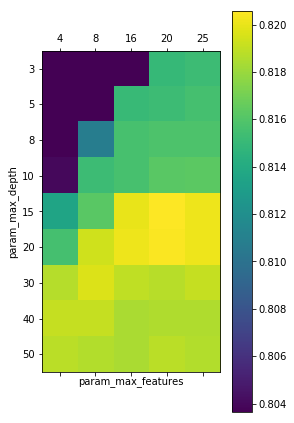

In [64]:
param_grid = {'max_depth': [3, 5, 8, 10, 15, 20, 30, 40, 50],
              'max_features':[4, 8, 16, 20, 25]}
grid = GridSearchCV(RandomForestClassifier(n_estimators=50),
                    param_grid=param_grid, cv=5, return_train_score=True)

# Mueller recommends subsetting the data by a factor of 10 in order to speed up the process.
# I follow his recommendation here

grid.fit(X_train[::10], y_train[::10])

res = pd.DataFrame(grid.cv_results_)
print(res.keys())
res_piv = pd.pivot_table(
    res, values='mean_test_score', index='param_max_depth',
    columns='param_max_features')

display(res_piv)

plt.matshow(res_piv.values)
plt.xlabel(res_piv.columns.name)
plt.xticks(range(res_piv.shape[1]), res_piv.columns)
plt.ylabel(res_piv.index.name)
plt.yticks(range(res_piv.shape[0]), res_piv.index);
plt.colorbar()

## Trying More Features
Creating a predictive model from a decision tree gave us results 1-2% better than randomness. Accounting for NAs in the minority class did not help to improve our model. Nor did tuning the hyperparameters and growing a random forest of 50 trees with 5-fold cross validation. I will attempt one more approach to improve the performance of this model: increase the number of features. I am also using `OneHotEncoder` to create the dummy variables because it does not increase the number of columns in the data as does `get_dummies`.

In [65]:
# create my data

bos311_pred_2 = pd.DataFrame(bos311_binary[['target', 
                                            'reason', 
                                            'subject', 
                                            'neighborhood', 
                                            'source', 
                                            'precinct', 
                                            'location_zipcode',
                                            'department',
                                            'fire_district',
                                            'pwd_district',
                                            'police_district',
                                            'city_council_district',
                                            'type',
                                            'queue']])
bos311_pred_2.head()

,target,reason,subject,neighborhood,source,precinct,location_zipcode,department,fire_district,pwd_district,police_district,city_council_district,type,queue
0,1,Street Lights,Public Works Department,Greater Mattapan,Employee Generated,1714,NaN,PWDx,8,07,B3,3,Street Light Outages,PWDx_Street Light Outages
1,1,Sanitation,Public Works Department,Roslindale,Self Service,2008,02131,PWDx,12,06,E5,5,Schedule a Bulk Item Pickup,PWDx_Schedule a Bulk Item Pickup
2,0,Street Lights,Public Works Department,Roxbury,Constituent Call,1103,NaN,PWDx,9,10B,E13,7,Street Light Outages,PWDx_Street Light_Pending_Contractor (Internal)
3,1,Highway Maintenance,Public Works Department,Dorchester,Employee Generated,1309,02125,PWDx,7,03,C11,3,Highway Maintenance,PWDx_District 03: North Dorchester
4,0,Recycling,Public Works Department,South Boston / South Boston Waterfront,Self Service,0701,02127,PWDx,6,05,C6,2,Sticker Request,PWDx_Sticker Request


To build the model, we need to first build a preprocessing pipeline. This pipeline will attempt to fill NAs with constant values and then convert categorical data into dummy values using `OneHotEncoder`. This data is then split into the train and test sets at a 80-20 ratio and a Logistic Regression is fit. The number of iterations is set high. (1000 opposed to the default of 100) to increase the likelihood of convergence. The accuracy is printed out at the end.

The code and approach used below is modified from the SciKit Learn examples documentation (Morales, 2019).

In [66]:
# Create the preprocessing pipelines for categorical data.
categorical_features = ['reason', 
                        'subject', 
                        'neighborhood',
                        'source', 
                        'precinct',
                        'location_zipcode',
                        'department',
                        'fire_district',
                        'pwd_district',
                        'police_district',
                        'city_council_district',
                        'type',
                        'queue']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='lbfgs', max_iter=1000))])

X2 = bos311_pred_2.drop('target', axis=1)
y2 = bos311_pred_2['target']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2)

clf.fit(X2_train, y2_train)
print("model score: %.3f" % clf.score(X2_test, y2_test))

model score: 0.868


These results are promising. By adding more features we gained 5% more accuracy over our initial Decision Tree and 7% over randomness.

# Conclusion
In this analysis I have used data publicly available from the City of Boston to learn about trends in non-emergency service requests made to the City over the past 8 years. The purpose of this analysis was to give Boston residents like me a better understanding of the trends in 3-1-1 service requests and to better understand the factors impacting how long a ticket remains open.

Through this analysis we have learned:
* That the average ticket remains open for about 9 hours and more than 50% of all tickets are closed within a day (24 hours)
* Dorchester had the greatest number of tickets
* Neighborhoods such as Beacon Hill, Downtown, and the South End experience the quickest resolution time (median) while Mattapan, Allston, and Roxbury experienced the slowest resolution time, over 3x as long.

We also learned that certain types of requests (e.g. civil rights requests) take much longer to resolve than request for public works. In the exploration of the data we can also identify key, external events that have driven the creation of certain kinds of tickets. For example, in the Winter of 2015 the City saw tickets for street cleaning and garbage pick-up spike as the city experienced records amount of snow.

Finally, we were able to create a predictive model that determines whether or not a ticket will be closed on time with 87% accuracy.

# References

City of Boston. (2019). _311 service requests_ [Dataset]. Retrieved from https://data.boston.gov/dataset/311-service-requests

City of Boston. (2019). _Neighborhood demographics_ [Dataset]. Retrieved from https://data.boston.gov/dataset/neighborhood-demographics

City of Boston. (2015). _BOS:311._ Retreived from https://www.cityofboston.gov/311/

Morales, P. (2019). _Column transformer with mixed types._ Retrieved from https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py

Mueller, Andeas. (2019). _Advanced machine learning with scikit learn part 1/11_ [Github Repository]. Retrieved from https://github.com/amueller/ml-workshop-3-of-4

Navlani, A. (2018, September 7). _Understanding logistic regression in Python._ Retrieved from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

Pathak, M. (2018, May 22). _Handling categorical data in Python._ Retrieved from https://www.datacamp.com/community/tutorials/categorical-data

WBUR News. (2015, August 11). _Boston rolls out 311 system for reporting non-emergency issues._ Retrieved from https://www.wbur.org/news/2015/08/11/311-non-emergency-reporting


In [67]:
end = datetime.now()
end

datetime.datetime(2019, 5, 17, 20, 28, 43, 29333)

In [68]:
end-start

datetime.timedelta(0, 1386, 735145)